# Load in the Data Using Generator

Each sample in the dataset has a unique ID. In the following code, when defining the generator, we first get the list of ID's from the RGB folder, then use the list of ID's to load the corresponding information of each sample. Associated with each sample is the following information (size and directory name for the training set are also listed):
    1. RGB image (512 * 512 * 3) (train/images/rgb)
    2. NIR image (512 * 512 * 1) (train/images/rgb)
    3. Boundary (512 * 512 * 1) (train/boundaries)
    4. Mask (512 * 512 * 1) (train/masks)
The task of this project is to use the information above to predict for each pixel, which of the six categories it belons to:
    1. Cloud shadow (512 * 512 * 1) (train/labels/cloud_shadow)
    2. Double plant (512 * 512 * 1) (train/labels/double_plant)
    3. Planter skip (512 * 512 * 1) (train/labels/planter_skip)
    4. Standing water (512 * 512 * 1) (train/labels/standing_water)
    5. Waterway (512 * 512 * 1) (train/labels/waterway)
    6. Weed cluster (512 * 512 * 1) (train/labels/weed_cluster)
If a pixel does not belong to any category above, it is considered to be
    0. Background

In [2]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import image as mpimg
from matplotlib import pyplot as plt
from typing import Callable, Union
from itertools import product
from scipy import stats

#keras imports
import keras
from keras.layers import Flatten
from keras.layers import Conv2D, MaxPooling2D, Input, BatchNormalization
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.merge import concatenate, add
from keras.layers.convolutional import Conv2DTranspose
from keras.utils import np_utils
from keras.models import Model
from keras.callbacks import Callback
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K
from tensorflow.keras.utils import to_categorical

%env SM_FRAMEWORK=tf.keras
import albumentations as A
import segmentation_models as sm 
import cv2

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [3]:
def id_check(path, ntail, ids):
    fignames = os.listdir(path)
    for fig_id in ids:
        if not fig_id + ntail in fignames:
            return False
    return True


def make_label(raw_labels):
    """
    This function creates a 7-channel label from the six labels (add a background channel).
    """
    stacked_labels = np.stack(raw_labels, axis=-1)
    last_label = np.sum(stacked_labels, axis=-1) + 1
    last_label[last_label > 1] = 0
    # Put the background as the last channel of the label
    full_labels =  np.concatenate([stacked_labels, last_label.reshape((512, 512, 1))], axis=-1)
    return full_labels / np.linalg.norm(full_labels, axis=-1).reshape((512, 512, 1))
    
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

def img_gen(dataset='train'):
    rgb_path = os.path.join(dataset, 'images', 'rgb')
    nir_path = os.path.join(dataset, 'images', 'nir')
    bdry_path = os.path.join(dataset, 'boundaries')
    mask_path = os.path.join(dataset, 'masks')
    label_names = ['cloud_shadow', 'double_plant', 'planter_skip', 'standing_water', 'waterway', 'weed_cluster']
    label_paths = [os.path.join(dataset, 'labels', label_name) for label_name in label_names]
    label = np.zeros((512,512,7))
    
    rgb_fig_names = os.listdir(rgb_path)
    fig_ids = [fname[:-4] for fname in rgb_fig_names]
    for fig_id in fig_ids:
        rgb_img = mpimg.imread(os.path.join(rgb_path, fig_id + '.jpg'))
        nir_img = mpimg.imread(os.path.join(nir_path, fig_id + '.jpg')).reshape((512, 512, 1))
        bdry_img = mpimg.imread(os.path.join(bdry_path, fig_id + '.png'))
        mask_img = mpimg.imread(os.path.join(mask_path, fig_id + '.png'))
        if dataset != "test":
            label_imgs = [mpimg.imread(os.path.join(label_path, fig_id + '.png')) for label_path in label_paths]
            label = make_label(label_imgs)
            
        input_img = np.concatenate([rgb_img, nir_img], axis=2) / 255. # Concatenate the RGB and NIR
        
        yield fig_id, input_img, bdry_img, mask_img, label
    
   
    
def masked_img_gen(dataset='train', use_augmentation=False):
    aug = A.Compose([  
        A.VerticalFlip(p=0.5),              
        A.RandomRotate90(p=0.5),]) 
    
    for fig_id, input_img, bdry_img, mask_img, label in img_gen(dataset):

        
        final_mask = np.multiply(bdry_img, mask_img).reshape(512, 512, 1) # Form the final mask
        masked_img = np.multiply(final_mask, input_img)
        masked_img = masked_img.reshape(-1, 512, 512, 4)
        
        if use_augmentation:
            augmented = aug(image=masked_img, mask=label)
            masked_img = augmented['image']
            label = augmented['mask']
                    
        if dataset != 'test':
            label = label.reshape(-1, 512, 512, 7)
            yield masked_img, label

        else:
            yield masked_img, fig_id
            
def rgb_masked_img_gen(dataset='train', use_augmentation=False):
    if dataset != 'test':
        for masked_img, label in masked_img_gen(dataset, use_augmentation):
            yield masked_img[:,:,:,0:3], label
        
    else:
        for masked_img, fig_id in masked_img_gen(dataset, use_augmentation):
             yield masked_img[:,:,:,0:3], fig_id

In [4]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # First layer.
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
               kernel_initializer = 'he_normal', padding = 'same', activation = 'relu')(input_tensor)
    
    x = BatchNormalization()(x)
    
    # Second layer.
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same', activation = 'relu')(x)
    
    return x

def createUnet(input_img, n_filters = 16, dropout = 0.1):
    
    # Down the Unet.
    conv1 = conv2d_block(input_img, n_filters)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(dropout)(pool1)
    
    conv2 = conv2d_block(pool1, n_filters*2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(dropout)(pool2)
    
    conv3 = conv2d_block(pool2, n_filters*4)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(dropout)(pool3)
    
    conv4 = conv2d_block(pool3, n_filters*8)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout)(pool4)
    
    # Bottom of the U-Net.
    conv5 = conv2d_block(pool4, n_filters*16)
    
    # Up the U.
    uconv4 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(conv5)
    uconv4 = concatenate([uconv4, conv4])
    uconv4 = conv2d_block(uconv4, n_filters*8)
    
    uconv3 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(uconv4)
    uconv3 = concatenate([uconv3, conv3])
    uconv3 = conv2d_block(uconv3, n_filters*4)
    
    uconv2 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(uconv3)
    uconv2 = concatenate([uconv2, conv2])
    uconv2 = conv2d_block(uconv2, n_filters*2)
    
    uconv1 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(uconv2)
    uconv1 = concatenate([uconv1, conv1])
    uconv1= conv2d_block(uconv1, n_filters*1)
    
    output = Conv2D(filters = 7, kernel_size = (1,1), activation = "softmax", padding = 'same')(uconv1)
    model = Model(inputs=[input_img], outputs=[output])
    return model

    

In [5]:
def weighted_categorical_crossentropy(weights):
    weights = K.variable(weights)
    def loss(y_true, y_pred):
        # Scale predictions so that the class probas of each sample sum to 1.
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # Clip to prevent NaN's and Inf's.
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # Calculate loss.
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
        
    return loss

def multiclass_weighted_dice_loss(class_weights: Union[list, np.ndarray, tf.Tensor]) -> Callable[[tf.Tensor, tf.Tensor], tf.Tensor]:
    if not isinstance(class_weights, tf.Tensor):
        class_weights = tf.constant(class_weights)

    def loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        # Reduce all axis but first (batch).
        axis_to_reduce = range(1, K.ndim(y_pred))  
        numerator = y_true * y_pred * class_weights  
        numerator = 2. * K.sum(numerator, axis=axis_to_reduce)

        denominator = (y_true + y_pred) * class_weights
        denominator = K.sum(denominator, axis=axis_to_reduce)

        return 1 - numerator / denominator

    return loss

In [6]:
learning_rate_reduction=ReduceLROnPlateau(monitor="MeanIoU", patience=2, verbose=0, factor=0.5, min_lr=0.0001)

train_path = os.path.join('train', 'images', 'rgb')
val_path = os.path.join('val', 'images', 'rgb')

steps_per_epoch = len(os.listdir(train_path))//32
validation_steps = len(os.listdir(val_path))//32

print("Steps per epoch: {}".format(steps_per_epoch))
print("Validation steps: {}".format(validation_steps))

Steps per epoch: 403
Validation steps: 138


# Train U-Net

In [7]:
keras.backend.clear_session()
input_img = Input((512, 512, 4), name='img')
model = createUnet(input_img, n_filters = 16, dropout = 0.1)

weights = 5 * np.ones((7,), dtype=np.float32)
weights[-1] = .1
print(weights)

model.compile(optimizer="adam", loss=multiclass_weighted_dice_loss(weights), metrics = [tf.keras.metrics.MeanIoU(num_classes=7, name = "MeanIoU")])
# model.compile(optimizer="adam", loss=weighted_categorical_crossentropy(weights), metrics = [tf.keras.metrics.MeanIoU(num_classes=7, name = "MeanIoU")])

model.summary()

[5.  5.  5.  5.  5.  5.  0.1]
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 512, 512, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 592         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 2320        batch_normalization[0][0]        
________________________________________________________________

In [8]:
# Train the model, doing validation at the end of each epoch.
epochs = 15
history = model.fit(masked_img_gen('train', False), epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=masked_img_gen('val'), validation_steps=validation_steps, use_multiprocessing=False, shuffle=True,\
         callbacks = [learning_rate_reduction])

Epoch 1/15
403/403 [==============================] - 29s 57ms/step - loss: 0.7475 - MeanIoU: 0.4301 - val_loss: 0.5559 - val_MeanIoU: 0.4613
Epoch 2/15
403/403 [==============================] - 22s 55ms/step - loss: 0.5897 - MeanIoU: 0.4465 - val_loss: 0.6660 - val_MeanIoU: 0.4344
Epoch 3/15
403/403 [==============================] - 22s 54ms/step - loss: 0.5693 - MeanIoU: 0.5167 - val_loss: 0.6004 - val_MeanIoU: 0.4898
Epoch 4/15
403/403 [==============================] - 21s 52ms/step - loss: 0.5698 - MeanIoU: 0.5842 - val_loss: 0.6010 - val_MeanIoU: 0.6463
Epoch 5/15
403/403 [==============================] - 21s 53ms/step - loss: 0.5346 - MeanIoU: 0.6322 - val_loss: 0.5170 - val_MeanIoU: 0.7116
Epoch 6/15
403/403 [==============================] - 21s 53ms/step - loss: 0.5344 - MeanIoU: 0.6101 - val_loss: 0.5608 - val_MeanIoU: 0.6862
Epoch 7/15
403/403 [==============================] - 20s 51ms/step - loss: 0.5434 - MeanIoU: 0.6130 - val_loss: 0.5642 - val_MeanIoU: 0.7392
Epoch 

# ResNet34-Based Network

In [ ]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

weights = 2 * np.ones((7,))
weights[-1] = 0.5

dice_loss = sm.losses.DiceLoss(class_weights=weights) 
total_loss = dice_loss + (1 * sm.losses.CategoricalFocalLoss())


# Define model.
# model = sm.Unet(BACKBONE, encoder_weights=None, input_shape = (512,512,4), classes = 7, activation = 'softmax')
model = sm.Unet(BACKBONE, encoder_weights='imagenet', input_shape = (512,512,3), classes = 7, activation = 'softmax')

model.compile(
    'Adam',
    loss=total_loss,
    metrics=[sm.metrics.IOUScore(class_weights = weights, name= "MeanIoU"), sm.metrics.FScore(threshold=0.5)],
)

model.summary()

In [111]:
epochs = 30
tf.keras.backend.clear_session()
# history = model.fit(rgb_masked_img_gen('train'), epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=rgb_masked_img_gen('val'), validation_steps=validation_steps, use_multiprocessing=False, shuffle=True, callbacks = [learning_rate_reduction])
history = model.fit(masked_img_gen('train'), epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=masked_img_gen('val'), validation_steps=validation_steps, use_multiprocessing=False, shuffle=True, callbacks = [learning_rate_reduction])

Epoch 1/30
403/403 [==============================] - 31s 69ms/step - loss: 0.9094 - MeanIoU: 0.0828 - f1-score: 0.6379 - val_loss: 0.9650 - val_MeanIoU: 0.0767 - val_f1-score: 0.7996
Epoch 2/30
403/403 [==============================] - 27s 68ms/step - loss: 0.8770 - MeanIoU: 0.1096 - f1-score: 0.8159 - val_loss: 1.0260 - val_MeanIoU: 0.0762 - val_f1-score: 0.6720
Epoch 3/30
403/403 [==============================] - 27s 68ms/step - loss: 0.8634 - MeanIoU: 0.1183 - f1-score: 0.7122 - val_loss: 0.8804 - val_MeanIoU: 0.1171 - val_f1-score: 0.7254
Epoch 4/30
403/403 [==============================] - 27s 68ms/step - loss: 0.8572 - MeanIoU: 0.1236 - f1-score: 0.6553 - val_loss: 0.8999 - val_MeanIoU: 0.1106 - val_f1-score: 0.6645
Epoch 5/30
403/403 [==============================] - 28s 69ms/step - loss: 0.8423 - MeanIoU: 0.1338 - f1-score: 0.6252 - val_loss: 0.8729 - val_MeanIoU: 0.1242 - val_f1-score: 0.7279
Epoch 6/30
403/403 [==============================] - 28s 69ms/step - loss: 0.84

# Output images

In [99]:
from PIL import Image
def outputTestImages(model, gen, ensemble):
    if not os.path.isdir('preds'):
        os.mkdir('preds')

    for mask_img, fig_id in gen('test'):
        y_pred = None
        if ensemble:
            y_pred = model(mask_img, 0)
        else:
            y_pred= model.predict(mask_img, verbose=0)

        pred_result = y_pred[0,:,:,:] # take the ith predictio


        # Since we appended the background to the last channel, we need to bring it to the front when saving predictions
        processed_result = np.concatenate([pred_result[:, :, -1].reshape((512, 512, 1)), pred_result[:, :, :-1]], axis=-1)
    #     print(processed_result.shape) # Should be (512, 512, 7)
        # Convert the 7-channel result to 1-channel result and cast to uint8

        final_pred = np.argmax(processed_result, axis=-1).astype(np.uint8)
    #     print(final_pred.shape) # Should be (512, 512)
        # Save the prediction
        filename = os.path.join('preds', fig_id + '.png')
        Image.fromarray(final_pred).save(filename)

# Ensemble model

In [ ]:
# define stacked model from multiple member input models
def define_stacked_model(members):
    # update all layers in all models to not be trainable
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            # make not trainable
            layer.trainable = False
            # rename to avoid 'unique layer name' issue
            layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
    # define multi-headed input
    ensemble_visible = [model.input for model in members]
    # concatenate merge output from each model
    ensemble_outputs = [model.output for model in members]
    merge = concatenate(ensemble_outputs)
    hidden = output = Conv2D(filters = 3, kernel_size = (1,1), activation = "relu", padding = 'same')(merge)
    output = output = Conv2D(filters = 7, kernel_size = (1,1), activation = "softmax", padding = 'same')(hidden)
    model = Model(inputs=ensemble_visible, outputs=output)
    # plot graph of ensemble
#     plot_model(model, show_shapes=True, to_file='model_graph.png')
    # compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model



In [ ]:
def buildAndTrainEnsemble(numUnet, lossFunc, optimizer, epochs):
    keras.backend.clear_session()
    models = []
    input_img = Input((512, 512, 4), name='img')
    
    for i in range (numUnet):
        
        
        model = createUnet(input_img)
        model.compile(optimizer=optimizer, loss=lossFunc, metrics = [tf.keras.metrics.MeanIoU(num_classes=7)])
        models.append(model)
        
    for m in models:
        m.fit(masked_img_gen('train'), epochs=epochs, steps_per_epoch=403, validation_data=masked_img_gen('val'), validation_steps=138, use_multiprocessing=False, shuffle=True)
    return models
    
def predictEnsemble(mods):
    def predict(img, verbose):
        preds = None
        for m in mods:
            pred = m.predict(img, verbose = verbose)

            if preds is None:
                preds = pred
            else:

                preds += pred

        return preds
    return predict

adamOpt = keras.optimizers.Adam(lr = .0001)
weights = 10 * np.ones((7,), dtype=np.float32)
weights[0] = .3
lossFunc = multiclass_weighted_dice_loss(weights)

models = buildAndTrainEnsemble(3, lossFunc, adamOpt, 20)

# Debug Image Predictions

In [112]:
new_gen = masked_img_gen('val', False)
new_rgb_gen = rgb_masked_img_gen('val', False)
new_img_gen = img_gen('val')

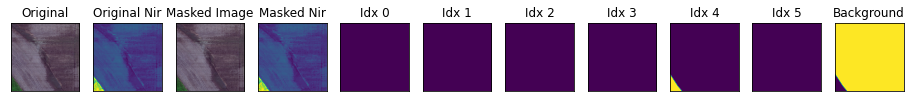

In [97]:
mask_img, label = next(new_gen)
fig_id, input_img, bdry_img, mask_img_old, label_old = next(new_img_gen)
visualize(
    original=input_img[:,:,0:3],
    original_nir = input_img[:,:,3],
    masked_image=mask_img[0,:,:,0:3], 
    masked_nir=mask_img[0,:,:,3],
    idx_0=label[0,:,:,0],
    idx_1=label[0,:,:,1],
    idx_2=label[0,:,:,2],
    idx_3=label[0,:,:,3],
    idx_4=label[0,:,:,4],
    idx_5=label[0,:,:,5],
    background=label[0,:,:,6]
)

In [ ]:
# Check an ensemble prediction

y_pred= predictEnsemble(models)(mask_img, verbose=0)

pred_result = y_pred[0,:,:,:] # take the ith predictio

processed_result = np.concatenate([pred_result[:, :, -1].reshape((512, 512, 1)), pred_result[:, :, :-1]], axis=-1)

final_pred = np.argmax(processed_result, axis=-1).astype(np.uint8)


In [113]:
# Check a regular prediction

mask_img, label = next(new_gen)

y_pred= model.predict(mask_img, verbose=0)

pred_result = y_pred[0,:,:,:] # take the ith predictio

processed_result = np.concatenate([pred_result[:, :, -1].reshape((512, 512, 1)), pred_result[:, :, :-1]], axis=-1)

print(processed_result.shape)

final_pred = np.argmax(processed_result, axis=-1).astype(np.uint8)

(512, 512, 7)


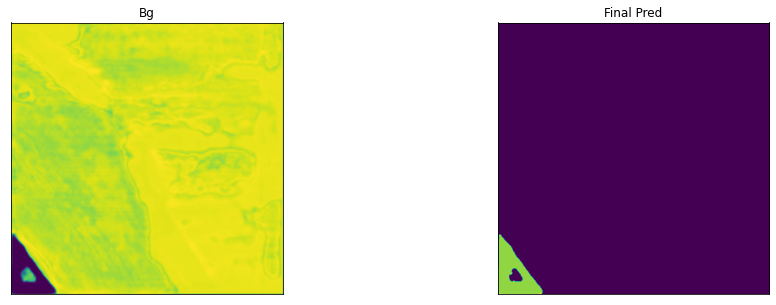

In [114]:
visualize(bg=processed_result[:,:,0], final_pred=final_pred)

In [ ]:
print(np.sum(final_pred))

In [ ]:
final_label = np.argmax(label[0,:,:,:], axis=-1).astype(np.uint8)

In [ ]:
# Check an individual prediction
print(label[0,0,0,:])
print(processed_result[0,0,:])
print(np.argmax(processed_result[0,0,:]))
a = tf.one_hot(tf.argmax(processed_result[0,0,:]), depth = 7)
print(a)

# Output Test Images

In [ ]:
outputTestImages(predictEnsemble(models), masked_img_gen, True)

In [116]:
outputTestImages(model, masked_img_gen, False)

# Output Training Graphs

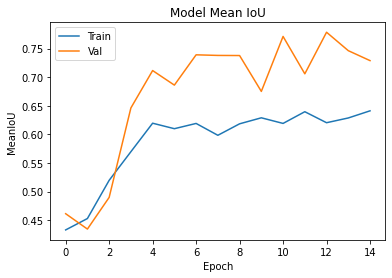

In [17]:
# summarize history for accuracy
plt.plot(history.history['MeanIoU'])
plt.plot(history.history['val_MeanIoU'])
plt.title('Model Mean IoU')
plt.ylabel('MeanIoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

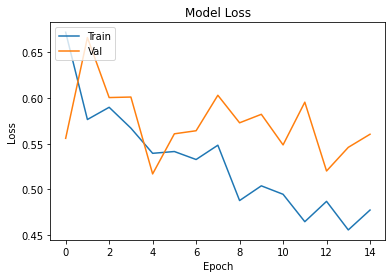

In [18]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()